# `pytket-mbqc` Simple Example
Here we present some simple use cases of `pytket-mbqc`.

## X Gate
The X can be implemented in brickwork style MBQC as the sequence H-Rz(pi)-H = J(pi)-H. This requires a three qubit cluster state entangle in a line. This is constructed by initialising an input qubit, a graph vertex and an output vertex. These are then connected in a line and measured together at the end.

WASM _w[0];
SetBits(00) index[0], index[1];
SetBits(0) meas_0[0];
SetBits(0) meas_1[0];
SetBits(0) meas_2[0];
Reset q[1];
Reset q[2];
SetBits(0) x_corr_0[0];
SetBits(0) x_corr_1[0];
SetBits(0) x_corr_2[0];
SetBits(0) z_corr_0[0];
SetBits(0) z_corr_1[0];
SetBits(0) z_corr_2[0];
WASM index[0], index[1], x_corr_0[0], _w[0];
H q[1];
H q[2];
WASM index[0], index[1], z_corr_0[0], _w[0];
CZ q[0], q[1];
SetBits(10) index[0], index[1];
IF ([x_corr_0[0]] == 1) THEN X q[0];
CZ q[1], q[2];
IF ([z_corr_0[0]] == 1) THEN Z q[0];
H q[0];
Measure q[0] --> meas_0[0];
WASM meas_0[0], index[0], index[1], _w[0];
SetBits(01) index[0], index[1];
WASM meas_0[0], index[0], index[1], _w[0];
SetBits(10) index[0], index[1];
WASM index[0], index[1], x_corr_1[0], _w[0];
WASM index[0], index[1], z_corr_1[0], _w[0];
IF ([x_corr_1[0]] == 1) THEN X q[1];
SetBits(01) index[0], index[1];
IF ([z_corr_1[0]] == 1) THEN Z q[1];
Z q[1];
H q[1];
Measure q[1] --> meas_1[0];
WASM meas_1[0], index[0], index[1], _w[0];
SetBits(01)

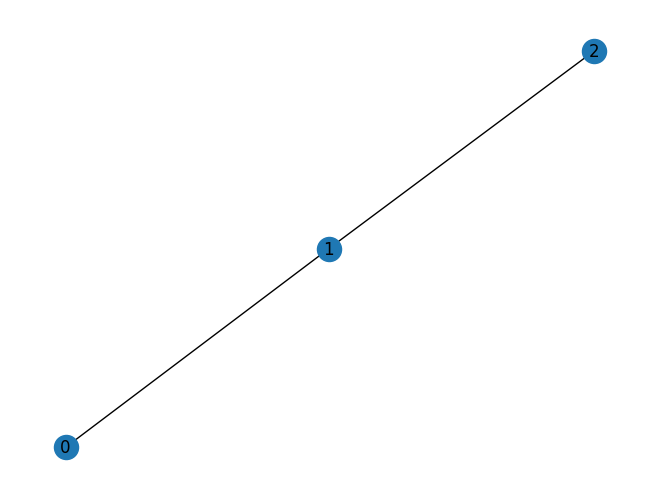

In [48]:
from pytket_mbqc_py import GraphCircuit
from pytket.unit_id import BitRegister
import networkx as nx
from pytket.circuit.display import render_circuit_jupyter

circuit = GraphCircuit(n_qubits_total=3)

input_qubit, index_one = circuit.add_input_vertex()

circuit.add_graph_vertex()
circuit.add_edge(vertex_one=0, vertex_two=1)

circuit.add_output_vertex()
circuit.add_edge(vertex_one=1, vertex_two=2)

circuit.corrected_measure(vertex=0, t_multiple=0)
circuit.corrected_measure(vertex=1, t_multiple=4)
circuit._apply_correction(vertex=2)

output_reg = BitRegister(name='output', size=1)
circuit.add_c_register(register=output_reg)
circuit.Measure(qubit=circuit.output_qubits[2], bit=output_reg[0])

print(*circuit.get_commands(), sep='\n')
nx.draw(circuit.graph, with_labels=True)

Let us run the resulting circuit. We should recover the 1 state 100% of the time as we are applying an X gate to the 0 state.

In [41]:
def get_colouring_dict(graph):
    coloring = nx.algorithms.coloring.greedy_color(graph)
    sorted_dict = dict(sorted(coloring.items()))
    return sorted_dict


Counter({(1,): 100})

In [71]:
def get_colouring_lists(colouring):
    unique_colors = set(colouring.values())
    lists_col = [[int(value == unique) for key, value in colouring.items()] for unique in unique_colors]
    return lists_col


In [72]:
graph = circuit.graph
colouring = get_colouring_dict(graph)
colouring_lists = get_colouring_lists(colouring)
print(colouring_lists)


[[0, 1, 0], [1, 0, 1]]


In [67]:
type(set(colouring.values()))
   

set

In [63]:
 [[int(value == unique) for key, value in colouring] for unique in unique_colors]

TypeError: cannot unpack non-iterable int object

In [66]:
type(colouring)

dict

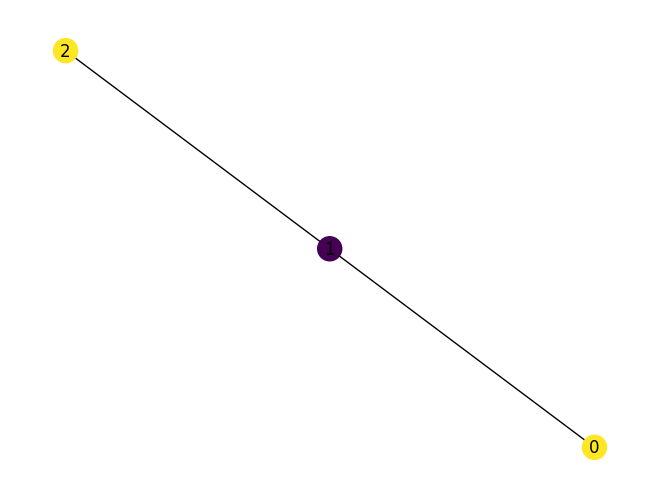

In [44]:
color_map = [coloring[node] for node in G.nodes]

# Draw the graph with the color map
nx.draw(G, node_color=color_map, with_labels=True)


In [45]:
from pytket_mbqc_py import get_wasm_file_handler
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline

backend = QuantinuumBackend(
    device_name="H1-1LE",
    api_handler=QuantinuumAPIOffline(),
)

compiled_circuit = backend.get_compiled_circuit(circuit)
result = backend.run_circuit(
    circuit=compiled_circuit,
    n_shots=100,
    wasm_file_handler=get_wasm_file_handler(),
)

result.get_counts(output_reg)

Counter({(1,): 100})

## CX Gate
The CX gate is more complicated. In this case the gate can be decomposed into brickwork MBQC native operations as H_2 - CZ - H_1 - H-2 H_1 - H_2 - H_2 where unserscore gives the qubit the operation acts on. Recall that CZ - H_1 - H_2 is the native two qubit gate in brickwork MBQC. We can construct this circuit as follows.

Note that in this case qubits can be measured before the whole graph state has been constructed. This allows for some qubits to be reused in this case.

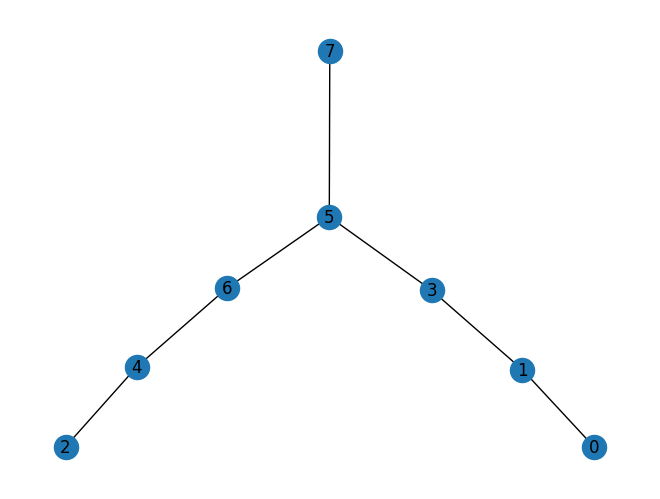

In [46]:
input_state = (1,0)

circuit = GraphCircuit(n_qubits_total=5)

target_qubit, _ = circuit.add_input_vertex()
if input_state[1]:
    circuit.X(target_qubit)

circuit.add_graph_vertex()
circuit.add_edge(vertex_one=0, vertex_two=1)

control_qubit, _ = circuit.add_input_vertex()
if input_state[0]:
    circuit.X(control_qubit)

circuit.add_graph_vertex()
circuit.add_edge(vertex_one=1, vertex_two=3)
circuit.corrected_measure(vertex=0, t_multiple=0)

circuit.add_graph_vertex()
circuit.add_edge(vertex_one=2, vertex_two=4)

circuit.add_graph_vertex()
circuit.add_edge(vertex_one=3, vertex_two=5)
circuit.corrected_measure(vertex=1, t_multiple=0)

circuit.add_output_vertex()
circuit.add_edge(vertex_one=4, vertex_two=6)
circuit.corrected_measure(vertex=2, t_multiple=0)

circuit.add_output_vertex()
circuit.add_edge(vertex_one=5, vertex_two=7)

circuit.add_edge(vertex_one=5, vertex_two=6)

circuit.corrected_measure(vertex=3, t_multiple=0)
circuit.corrected_measure(vertex=4, t_multiple=0)
circuit.corrected_measure(vertex=5, t_multiple=0)

circuit.correct_outputs()
output_reg = BitRegister(name='output', size=2)
circuit.add_c_register(register=output_reg)
circuit.Measure(qubit=circuit.output_qubits[6], bit=output_reg[0])
circuit.Measure(qubit=circuit.output_qubits[7], bit=output_reg[1])

nx.draw(circuit.graph, with_labels=True)

Having initialised the |10> state above we expect to measure |11> 100% of the time, as we indeed do.

In [47]:
compiled_circuit = backend.get_compiled_circuit(circuit)

n_shots = 100
result = backend.run_circuit(
    circuit=compiled_circuit,
    n_shots=n_shots,
    wasm_file_handler=get_wasm_file_handler(),
)

result.get_counts(output_reg)

Counter({(1, 1): 100})

In [76]:
True is not False

True

In [77]:
def test(c,ca=None):
    if ca is None:
        ca = c
    print(c, ca)

In [79]:
test(1,3)

1 3


In [82]:
import random

random_number = random.randint(0, 1)
print(random_number)

1
